# MAUP (problema da unidade de área modificável)

Além da dependência espacial e da heterogeneidade espacial (os efeitos espaciais), existem alguns problemas que podem afetar a análise de dados espaciais:

- falácia ecológica
- unidade de área modificável (MAUP) - sensibilidade dos resultados em relação à dimensão e à configuração da área de estudo
- efeito de beirada
- influência de *outliers* espaciais

Os resultados de uma análise de dados dependem da definição do critério usado para a agregação espacial dos dados.




---



---


MAUP = problema de escala + problema de zoneamento

---





- O MAUP se manifesta na situação em que os resultados da análise são sensíveis à forma como os dados espaciais são organizados (nível de escala e zoneamento)
- Uma escolha inadequada da escala geográfica pode gerar dependência espacial artificial
- O MAUP limita a possibilidade de replicação de um modelo a uma outra região de estudo, se a escala e o zoneamento forem distintos daqueles da aplicação inicial

- Se os dados fossem distribuídos aleatoriamente no espaço, o problema de escala não apareceria
- O problema de escala vincula-se ao efeito da dependência espacial
- Se o espaço fosse absolutamente homogêneo, qualquer combinação de unidades espaciais em zonas forneceria os mesmos resultados (não haveria o problema de zoneamento)

# MAUP em MG

In [ ]:
!pip install geopandas==0.8.2
!pip install --upgrade pyshp
!pip install shapely  ==1.7.0
!pip install --upgrade descartes
!pip install mapclassify==2.3.0 libpysal==4.3.0 splot==1.1.3
!pip install esda
!pip install pysal

     |████████████████████████████████| 962 kB 7.4 MB/s 
     |████████████████████████████████| 6.3 MB 29.2 MB/s 
     |████████████████████████████████| 16.7 MB 1.6 MB/s 
     |████████████████████████████████| 44 kB 1.8 MB/s 
ERROR: Invalid requirement: '==1.7.0'
     |████████████████████████████████| 2.4 MB 12.9 MB/s 
     |████████████████████████████████| 95 kB 3.8 MB/s 
     |████████████████████████████████| 209 kB 51.9 MB/s 
     |████████████████████████████████| 60 kB 6.4 MB/s 
     |████████████████████████████████| 269 kB 50.3 MB/s 
  Created wheel for libpysal: filename=libpysal-4.3.0-py2.py3-none-any.whl size=2379095 sha256=8e3527876da20432ffd8014c8290d1f7bb5dfad8918438bec076f355fc630094
  Stored in directory: /root/.cache/pip/wheels/a9/33/82/a0dde6150f4719939514a575369d4b49f89f5525feabc6d997
  Created wheel for splot: filename=splot-1.1.3-py3-none-any.whl size=37888 sha256=1cfcf5ea885f897e9b8061d072787951c4d3580f1a2392a75e03fe910f691af7
  Stored in directory: /root/.ca

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import statsmodels.formula.api as sm

# para gráficos
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns

# para a análise de dados espaciais
import geopandas as gp
import pysal as ps
import splot
import mapclassify as mc
from libpysal.weights import Queen
from libpysal import weights
from esda import Moran, Moran_Local, G_Local
from splot.esda import plot_moran, moran_scatterplot, lisa_cluster, plot_local_autocorrelation

# links com arquivos úteis
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/'
link_p = 'https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/'

# Nível de agregação: municípios

## Quantidade produzida

Dados de 2017

In [2]:
# ler dados de interesse
dados = pd.read_csv('https://raw.githubusercontent.com/patriciasiqueira/patriciasiqueira.github.io/master/arquivos/qtde-cod-18-mg.csv', encoding='latin1')
link = 'https://raw.githubusercontent.com/lincolnfrias/dados/master/mg.json'
geodf = gp.read_file(link)   # ler shapefile de MG
# mesclar shapefile com dataframe usando a coluna mun
geodf.rename(columns={'CD_GEOCMU': 'mun'}, inplace=True)  # mudar nome da coluna com cód. para 'mun'
geodf['mun'] = geodf.mun.astype(int)  # transformar códigos em inteiros
mg = pd.merge(geodf, dados, on='mun', suffixes=('', '_y'))  # mesclar o dataframe e o shapefile em um objeto
mg = mg.loc[:, mg.columns != 'NM_MUNICIP']  # tirar a coluna NM_MUNICIP

In [3]:
mg.columns

Index(['mun', 'geometry', 'nome_mun', 'uf', 'nome_uf', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'cod_rgi', 'nome_rgi', 'cod_rgint',
       'nome_rgint', 'codmun6', 'regiao', 'nome_regiao', 'area', 'algodao_arb',
       'algodao_herb', 'banana', 'batata', 'cafe_arab', 'cana', 'feijao',
       'laranja', 'limao', 'manga', 'milho', 'soja', 'sorgo', 'tangerina',
       'tomate', 'trigo', 'leite', 'ovos', 'mel'],
      dtype='object')

In [4]:
mg.query("nome_mun == 'Varginha'")

mun                                           geometry  nome_mun  uf  \
832  3170701  POLYGON ((-45.36476 -21.48118, -45.29135 -21.5...  Varginha  31   

          nome_uf   rm  meso              nome_meso  micro nome_micro  ...  \
832  Minas Gerais  NaN  3110  Sul/Sudoeste de Minas  31050   Varginha  ...   

     manga milho  soja sorgo  tangerina  tomate trigo  leite  ovos   mel  
832      0  2400   420     0          0       0     0   6604    53  2700  

[1 rows x 37 columns]

In [5]:
variavel = 'banana'      # escolher a variável e colocar entre aspas

In [6]:
# total da produção de banana em MG em 2017
mg[variavel].sum()

685471

In [7]:
# resumo estatístico
mg[variavel].describe()

count       853.000000
mean        803.600234
std        6226.590290
min           0.000000
25%           0.000000
50%          30.000000
75%         145.000000
max      154710.000000
Name: banana, dtype: float64

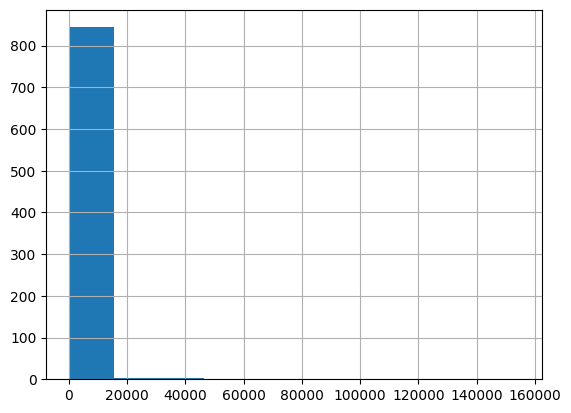

In [8]:
# histograma
mg[variavel].hist();

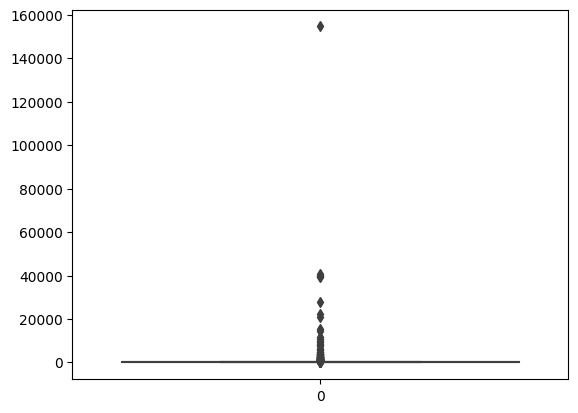

In [9]:
# boxplot
sns.boxplot(mg[variavel], orient='v');

In [10]:
# visualizar os municípios em ordem decrescente (ou crescente)
mg.sort_values(variavel, ascending=False)[['nome_mun', 'nome_meso', variavel]].head(10)

nome_mun                         nome_meso  banana
395             Jaíba                    Norte de Minas  154710
234      Delfinópolis             Sul/Sudoeste de Minas   40779
417        Nova União   Metropolitana de Belo Horizonte   39900
521  Nova Porteirinha                    Norte de Minas   39725
397           Janaúba                    Norte de Minas   39360
837       Verdelândia                    Norte de Minas   28000
471    Matias Cardoso                    Norte de Minas   22470
822        Uberlândia  Triângulo Mineiro/Alto Paranaíba   21080
225          Cristina             Sul/Sudoeste de Minas   15600
597          Pirapora                    Norte de Minas   14268

In [11]:
mg[mg.nome_mun == "Jaíba"]

mun                                           geometry nome_mun  uf  \
395  3135050  POLYGON ((-43.52520 -14.97730, -43.50331 -14.9...    Jaíba  31   

          nome_uf   rm  meso       nome_meso  micro nome_micro  ...  manga  \
395  Minas Gerais  NaN  3102  Norte de Minas  31004    Janaúba  ...   9223   

     milho  soja sorgo  tangerina  tomate trigo  leite  ovos  mel  
395  14700    50    90       3000   48613     0   2620   141   50  

[1 rows x 37 columns]

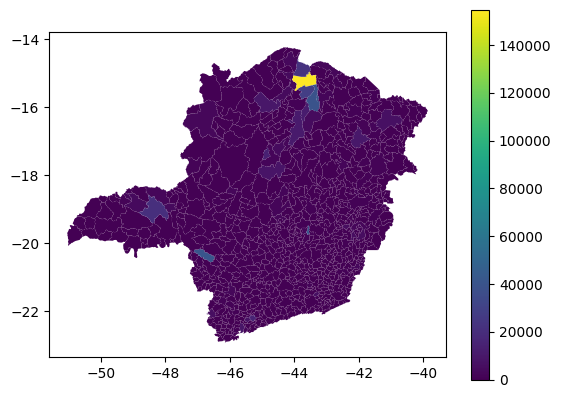

In [12]:
# mapa temático - simples
mg.plot(variavel, legend=True);

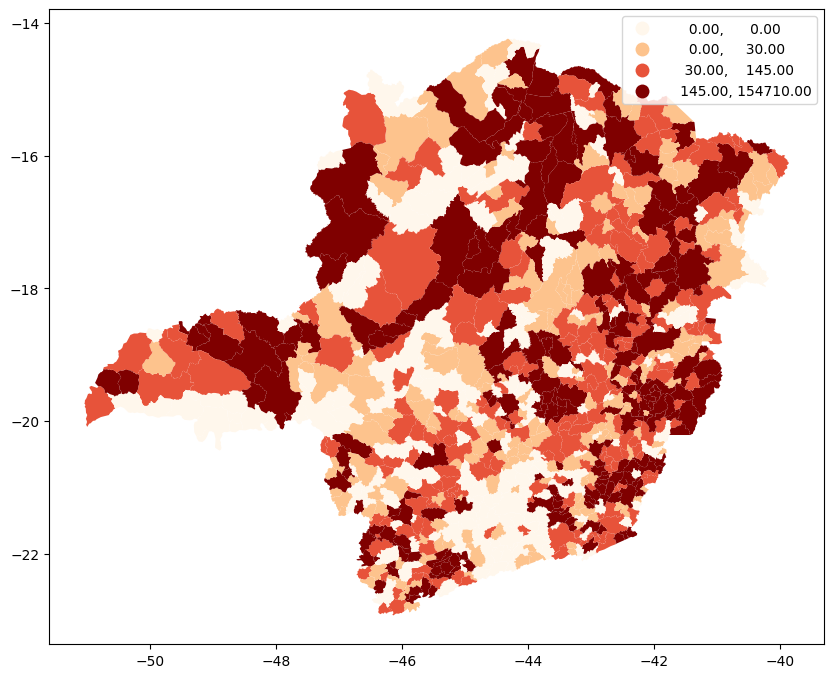

In [14]:
# mapa temático - quantiles
mg.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

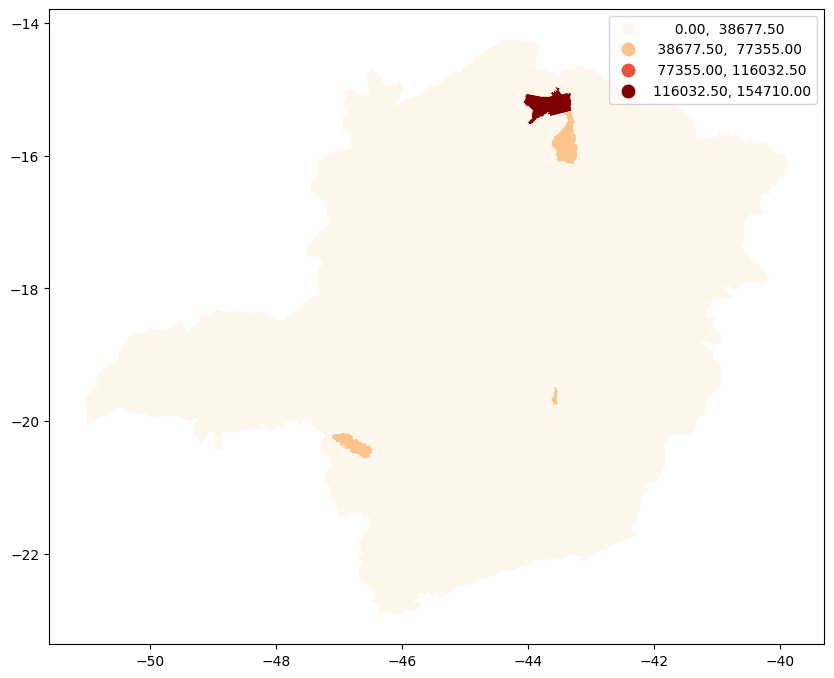

In [15]:
# mapa temático - equal_interval
mg.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [16]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(mg)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = mg[variavel].values
moran = Moran(y, w)
moran.I

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\133696228.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(mg)


0.16236018405991934

In [17]:
# valor-p
moran.p_sim

0.001

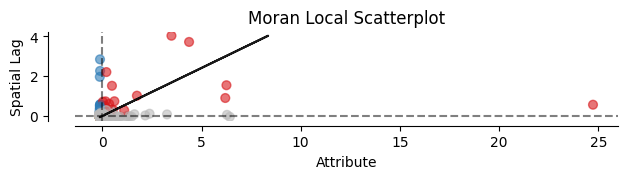

In [18]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

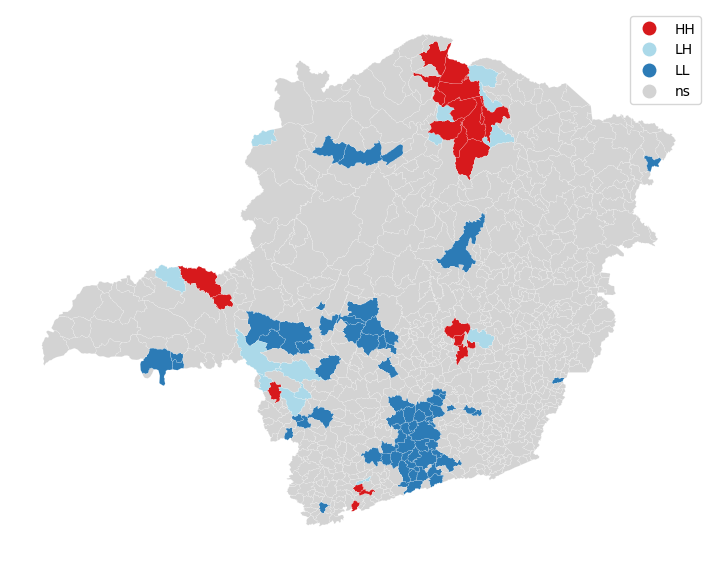

In [19]:
# mapa LISA
lisa_cluster(moran_loc, mg, p=0.05, figsize = (9,9));

# Nível de agregação: mesorregiões

In [20]:
# agrupar municípios em mesorregiões
# mapa contém as informações divididas em municípios e queremos unir os
# municípios em mesorregiões
# uso da função dissolve
# agrupar de acordo com as mesorregiões (código e nome)
# somar os valores dos municípios presentes em cada mesorregião
mesos = mg.dissolve(by=['meso', 'nome_meso'], aggfunc='sum')
mesos.head(3)

geometry  \
meso nome_meso                                                              
3101 Noroeste de Minas  POLYGON ((-46.12555 -18.52319, -46.13922 -18.5...   
3102 Norte de Minas     POLYGON ((-44.28615 -17.73037, -44.29169 -17.7...   
3103 Jequitinhonha      POLYGON ((-43.56443 -18.70425, -43.57893 -18.6...   

                              mun  \
meso nome_meso                      
3101 Noroeste de Minas   59617360   
3102 Norte de Minas     279428401   
3103 Jequitinhonha      159812163   

                                                                 nome_mun  \
meso nome_meso                                                              
3101 Noroeste de Minas  ArinosBonfinópolis de MinasBrasilândia de Mina...   
3102 Norte de Minas     Águas VermelhasBerizalBocaiúvaBonito de MinasB...   
3103 Jequitinhonha      AlmenaraCachoeira de PajeúAngelândiaAraçuaíAri...   

                          uf  \
meso nome_meso                 
3101 Noroeste de Minas   589   
3102 Norte de Minas     2759   
3103 Jequitinhonha      1581   

                                                                  nome_uf  \
meso nome_meso                                                              
3101 Noroeste de Minas  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
3102 Norte de Minas     Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
3103 Jequitinhonha      Minas GeraisMinas GeraisMinas GeraisMinas Gera...   

                                                                       rm  \
meso nome_meso                                                              
3101 Noroeste de Minas  RIDE - Região Integrada de Desenvolvimento do ...   
3102 Norte de Minas                                                     0   
3103 Jequitinhonha                                                      0   

                          micro  \
meso nome_meso                    
3101 Noroeste de Minas   589029   
3102 Norte de Minas     2759492   
3103 Jequitinhonha      1581619   

                                                               nome_micro  \
meso nome_meso                                                              
3101 Noroeste de Minas  UnaíUnaíParacatuUnaíUnaíUnaíUnaíParacatuParaca...   
3102 Norte de Minas     SalinasSalinasBocaiúvaJanuáriaGrão MogolMontes...   
3103 Jequitinhonha      AlmenaraPedra AzulCapelinhaAraçuaíCapelinhaAlm...   

                         cod_rgi  \
meso nome_meso                     
3101 Noroeste de Minas   5891187   
3102 Norte de Minas     27590841   
3103 Jequitinhonha      15810784   

                                                                 nome_rgi  \
meso nome_meso                                                              
3101 Noroeste de Minas  UnaíUnaíPatos de MinasUnaíUnaíUnaíUnaíPatos de...   
3102 Norte de Minas     Pedra AzulSalinasMontes ClarosJanuáriaMontes C...   
3103 Jequitinhonha      AlmenaraPedra AzulCapelinhaAraçuaíCapelinhaAlm...   

                        ...  manga    milho     soja  sorgo tangerina  tomate  \
meso nome_meso          ...                                                     
3101 Noroeste de Minas  ...   4659  1385818  1793442  91241        16   79030   
3102 Norte de Minas     ...  38391   179322   135157   5967     14598   75126   
3103 Jequitinhonha      ...   1863    18170        0      0        87    4406   

                        trigo   leite   ovos     mel  
meso nome_meso                                        
3101 Noroeste de Minas  10648  545274   3905   29710  
3102 Norte de Minas         0  221511  62115  504656  
3103 Jequitinhonha          0  161822   4348  582938  

[3 rows x 35 columns]

In [21]:
# reiniciar índices e retirar as colunas que não serão usadas
mesos = mesos.reset_index()
# retirar = ['mun', 'uf', 'micro', 'cod_rgi', 'nome_rgi', 'nome_rgint', 'codmun6', 'regiao', 'nome_regiao', 'area']
# mesos = mesos.drop(retirar, axis=1)

In [22]:
# resumo estatístico
mesos[variavel].describe()

count        12.000000
mean      57122.583333
std      104758.404912
min        1666.000000
25%        4008.000000
50%       26232.000000
75%       46940.250000
max      375459.000000
Name: banana, dtype: float64

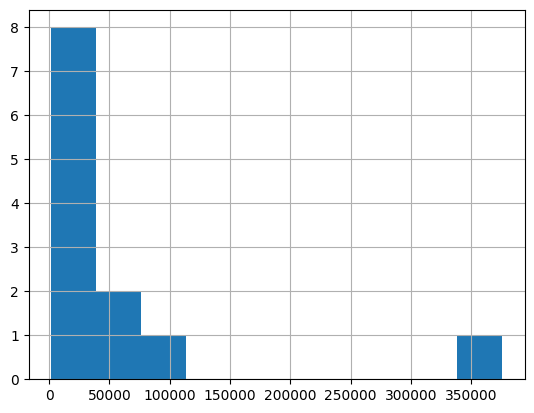

In [23]:
mesos[variavel].hist();

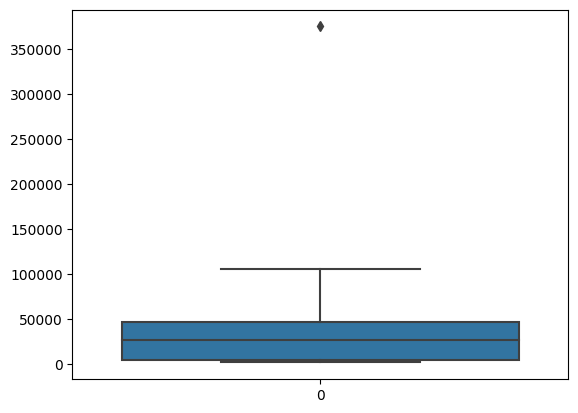

In [24]:
# boxplot
sns.boxplot(mesos[variavel], orient='v');

In [25]:
# visualizar as mesorregiões em ordem decrescente (ou crescente)
mesos.sort_values(variavel, ascending=False)[['nome_meso', variavel]].head(10)

nome_meso  banana
1                     Norte de Minas  375459
9              Sul/Sudoeste de Minas  105845
6    Metropolitana de Belo Horizonte   59277
4   Triângulo Mineiro/Alto Paranaíba   42828
7                   Vale do Rio Doce   29558
11                      Zona da Mata   27122
2                      Jequitinhonha   25342
0                  Noroeste de Minas    7712
10               Campo das Vertentes    4021
3                     Vale do Mucuri    3969

In [26]:
variavel

'banana'

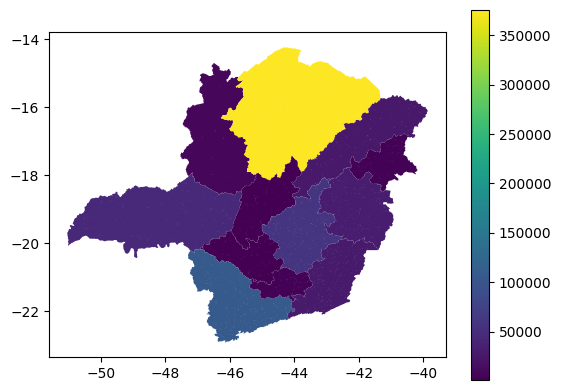

In [27]:
# mapa temático - simples
mesos.plot(variavel, legend=True);

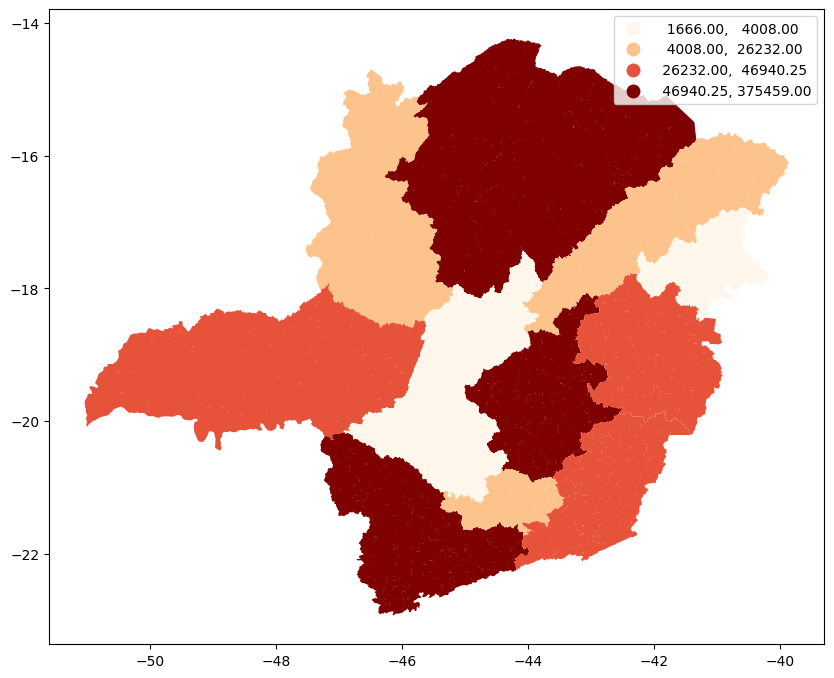

In [30]:
# mapa temático - quantiles
mesos.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

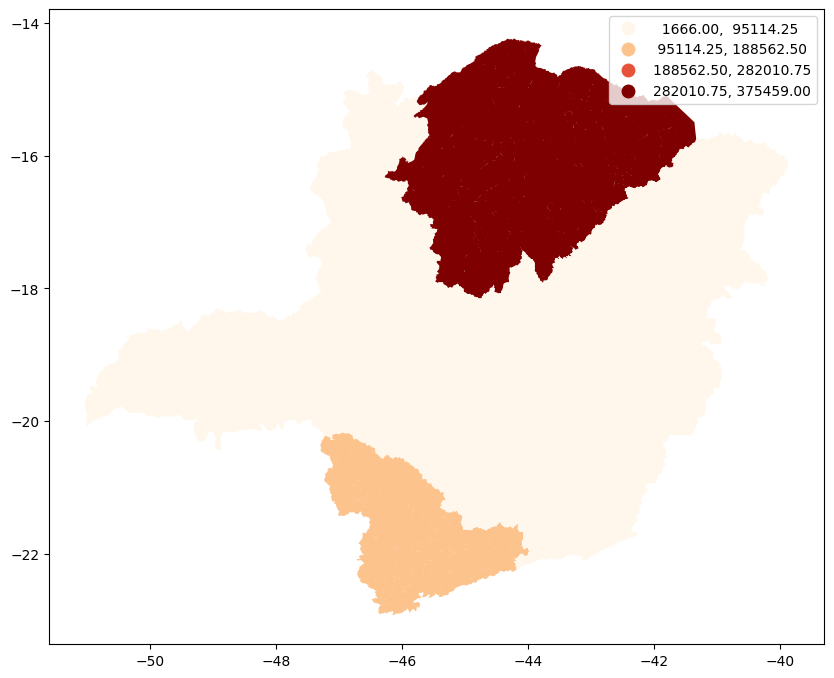

In [31]:
# mapa temático - equal_interval
mesos.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [ ]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(mesos)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = mesos[variavel].values
moran = Moran(y, w)
moran.I

-0.15700987910828637

In [ ]:
# valor-p
moran.p_sim

0.198

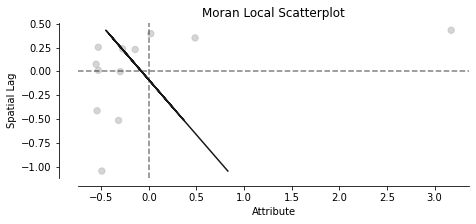

In [ ]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

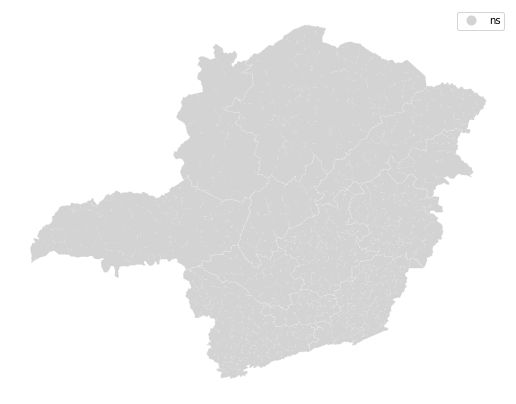

In [ ]:
# mapa LISA
lisa_cluster(moran_loc, mesos, p=0.05, figsize = (9,9));

# Nível de agregação: microrregiões

In [32]:
micros = mg.dissolve(by=['micro', 'nome_micro'], aggfunc='sum')
micros.head(3)

geometry       mun  \
micro nome_micro                                                                
31001 Unaí        POLYGON ((-46.18729 -16.87954, -46.18358 -16.9...  28165398   
31002 Paracatu    POLYGON ((-45.79158 -18.49716, -45.80473 -18.5...  31451962   
31003 Januária    POLYGON ((-44.84777 -16.27158, -44.88404 -16.2...  50235487   

                                                           nome_mun   uf  \
micro nome_micro                                                           
31001 Unaí        ArinosBonfinópolis de MinasBuritisCabeceira Gr...  279   
31002 Paracatu    Brasilândia de MinasGuarda-MorJoão PinheiroLag...  310   
31003 Januária    Bonito de MinasChapada GaúchaCônego MarinhoIca...  496   

                                                            nome_uf  \
micro nome_micro                                                      
31001 Unaí        Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
31002 Paracatu    Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
31003 Januária    Minas GeraisMinas GeraisMinas GeraisMinas Gera...   

                                                                 rm   meso  \
micro nome_micro                                                             
31001 Unaí        RIDE - Região Integrada de Desenvolvimento do ...  27909   
31002 Paracatu                                                    0  31010   
31003 Januária                                                    0  49632   

                                                          nome_meso  cod_rgi  \
micro nome_micro                                                               
31001 Unaí        Noroeste de MinasNoroeste de MinasNoroeste de ...  2790567   
31002 Paracatu    Noroeste de MinasNoroeste de MinasNoroeste de ...  3100620   
31003 Januária    Norte de MinasNorte de MinasNorte de MinasNort...  4960200   

                                                           nome_rgi  ...  \
micro nome_micro                                                     ...   
31001 Unaí                     UnaíUnaíUnaíUnaíUnaíUnaíUnaíUnaíUnaí  ...   
31002 Paracatu    Patos de MinasPatos de MinasPatos de MinasPato...  ...   
31003 Januária    JanuáriaSão FranciscoJanuáriaSão FranciscoJanu...  ...   

                  manga   milho     soja  sorgo tangerina  tomate  trigo  \
micro nome_micro                                                           
31001 Unaí          316  729766  1038781  50315         0    1030   2991   
31002 Paracatu     4343  656052   754661  40926        16   78000   7657   
31003 Januária    11094   31828    41519   1030       248   19410      0   

                   leite  ovos     mel  
micro nome_micro                        
31001 Unaí        155295  2012   14485  
31002 Paracatu    389979  1893   15225  
31003 Januária     44556  1954  106010  

[3 rows x 35 columns]

In [33]:
# reiniciar índices
micros = micros.reset_index()

In [34]:
# resumo estatístico
micros[variavel].describe()

count        66.000000
mean      10385.924242
std       31254.579870
min          48.000000
25%         502.750000
50%        1699.500000
75%        4766.250000
max      238808.000000
Name: banana, dtype: float64

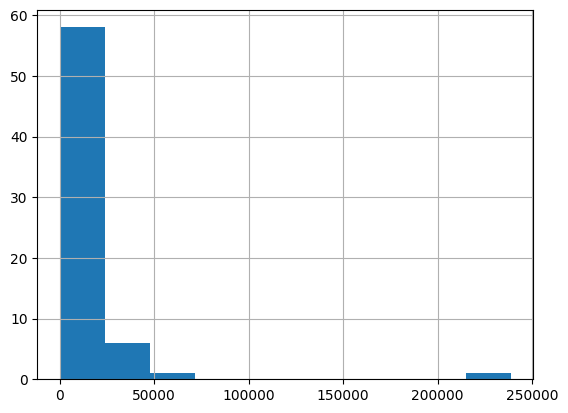

In [35]:
micros[variavel].hist();

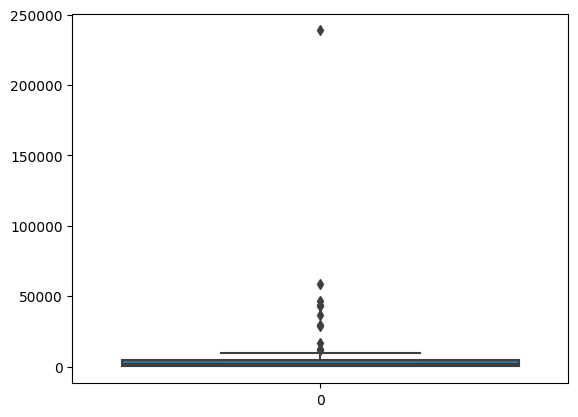

In [36]:
# boxplot
sns.boxplot(micros[variavel], orient='v');

In [37]:
# visualizar as regiões em ordem decrescente (ou crescente)
micros.sort_values(variavel, ascending=False)[['nome_micro', variavel]].head(10)

nome_micro  banana
3         Janaúba  238808
6   Montes Claros   58797
30        Itabira   46621
2        Januária   43691
46         Passos   43221
17     Uberlândia   36939
5        Pirapora   29405
55        Itajubá   28833
39      Caratinga   16405
11        Araçuaí   12751

In [38]:
micros

micro    nome_micro                                           geometry  \
0   31001          Unaí  POLYGON ((-46.18729 -16.87954, -46.18358 -16.9...   
1   31002      Paracatu  POLYGON ((-45.79158 -18.49716, -45.80473 -18.5...   
2   31003      Januária  POLYGON ((-44.84777 -16.27158, -44.88404 -16.2...   
3   31004       Janaúba  POLYGON ((-42.80395 -15.60572, -42.79830 -15.6...   
4   31005       Salinas  POLYGON ((-41.95113 -16.40266, -41.98782 -16.3...   
..    ...           ...                                                ...   
61  31062        Viçosa  POLYGON ((-43.15364 -20.87661, -43.16420 -20.8...   
62  31063        Muriaé  POLYGON ((-42.22849 -21.28165, -42.22930 -21.3...   
63  31064           Ubá  POLYGON ((-43.00002 -21.39205, -43.01894 -21.4...   
64  31065  Juiz de Fora  POLYGON ((-44.06735 -22.16202, -44.08721 -22.1...   
65  31066    Cataguases  POLYGON ((-42.60828 -21.83927, -42.60533 -21.8...   

          mun                                           nome_mun    uf  \
0    28165398  ArinosBonfinópolis de MinasBuritisCabeceira Gr...   279   
1    31451962  Brasilândia de MinasGuarda-MorJoão PinheiroLag...   310   
2    50235487  Bonito de MinasChapada GaúchaCônego MarinhoIca...   496   
3    40825710  CatutiEspinosaGameleirasJaíbaJanaúbaMamonasMat...   403   
4    53430391  Águas VermelhasBerizalCurral de DentroDivisa A...   527   
..        ...                                                ...   ...   
61   62711984  Alto Rio DoceAmparo do SerraArapongaBrás Pires...   620   
62   62748598  Antônio Prado de MinasBarão de Monte AltoCaian...   620   
63   53514348  Astolfo DutraDivinésiaDores do TurvoGuaraniGui...   527   
64  103618727  AracitabaBelmiro BragaBias FortesBicasChácaraC...  1023   
65   43920158  Além ParaíbaArgiritaCataguasesDona EusébiaEstr...   434   

                                              nome_uf  \
0   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
1   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
2   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
3   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
4   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
..                                                ...   
61  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
62  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
63  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
64  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
65  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   

                                                   rm    meso  \
0   RIDE - Região Integrada de Desenvolvimento do ...   27909   
1                                                   0   31010   
2                                                   0   49632   
3                                                   0   40326   
4                                                   0   52734   
..                                                ...     ...   
61                                                  0   62240   
62                                                  0   62240   
63                                                  0   52904   
64                                                  0  102696   
65                                                  0   43568   

                                            nome_meso  ...  manga   milho  \
0   Noroeste de MinasNoroeste de MinasNoroeste de ...  ...    316  729766   
1   Noroeste de MinasNoroeste de MinasNoroeste de ...  ...   4343  656052   
2   Norte de MinasNorte de MinasNorte de MinasNort...  ...  11094   31828   
3   Norte de MinasNorte de MinasNorte de MinasNort...  ...  22070   16422   
4   Norte de MinasNorte de MinasNorte de MinasNort...  ...   2451    5550   
..                                                ...  ...    ...     ...   
61  Zona da MataZona da MataZona da MataZona da Ma...  ...     16   56033   
62  Zona da MataZona da MataZona da MataZona da Ma...  ...     16    9407   
63  Zona da MataZon

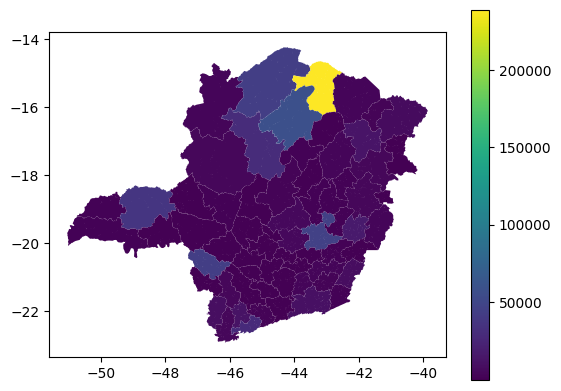

In [39]:
# mapa temático - simples
micros.plot(variavel, legend=True);

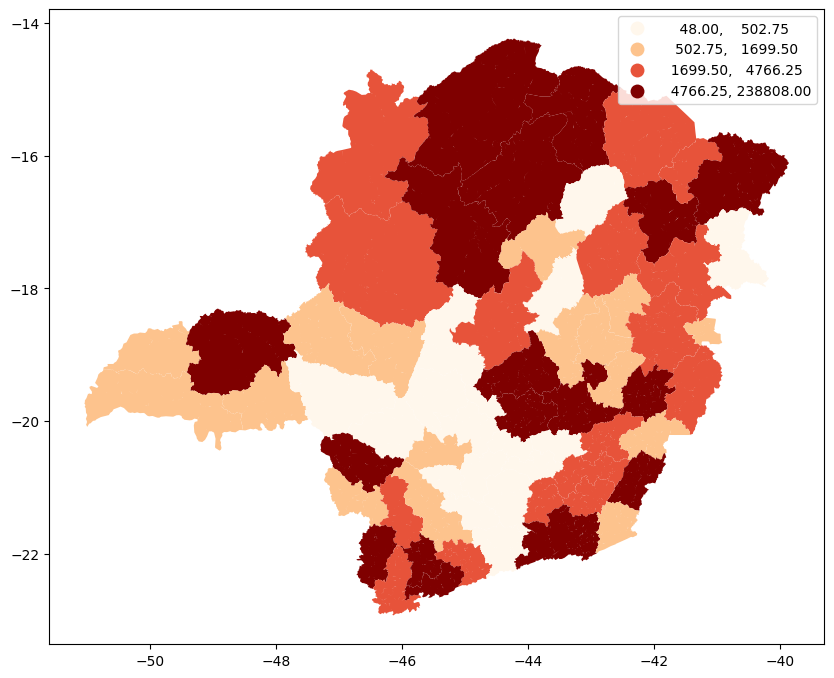

In [40]:
# mapa temático - quantiles
micros.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

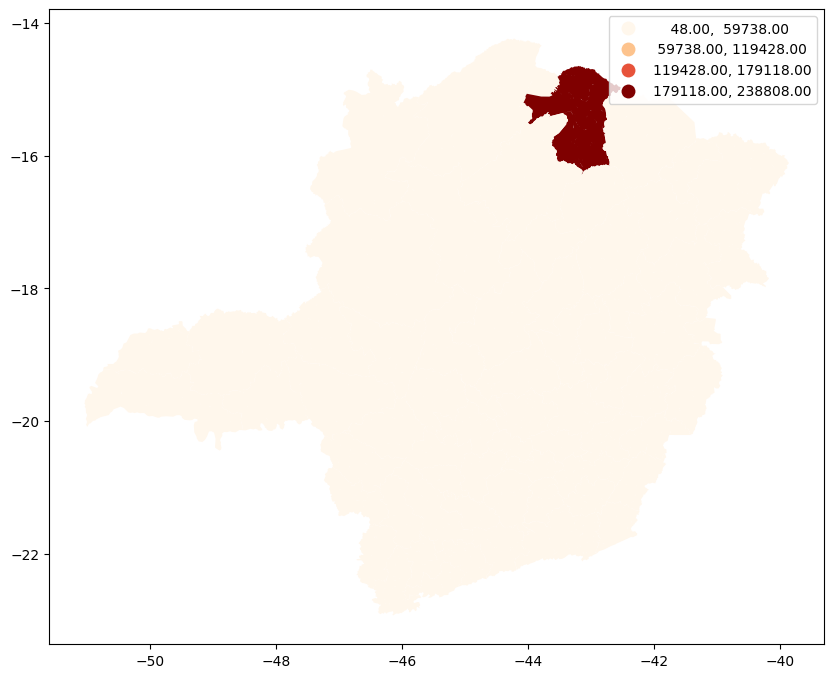

In [41]:
# mapa temático - equal_interval
micros.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [ ]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(micros)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = micros[variavel].values
moran = Moran(y, w)
moran.I

0.13330079217195764

In [ ]:
# valor-p
moran.p_sim

0.006

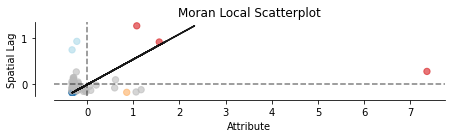

In [ ]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

ValueError: Length of values (853) does not match length of index (66)

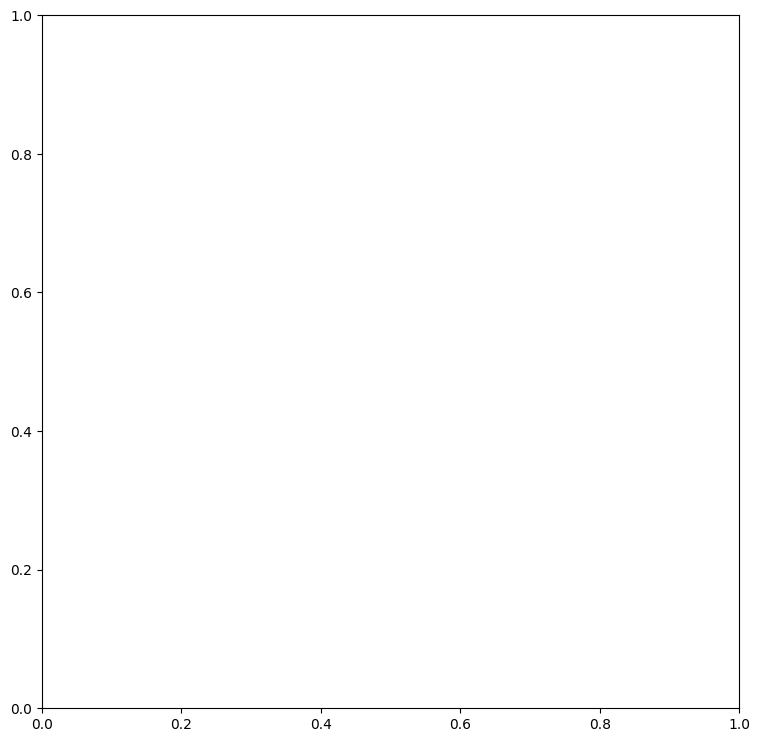

In [42]:
# mapa LISA
lisa_cluster(moran_loc, micros, p=0.05, figsize = (9,9));

# Nível de agregação: regiões intermediárias

In [43]:
mg.columns

Index(['mun', 'geometry', 'nome_mun', 'uf', 'nome_uf', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'cod_rgi', 'nome_rgi', 'cod_rgint',
       'nome_rgint', 'codmun6', 'regiao', 'nome_regiao', 'area', 'algodao_arb',
       'algodao_herb', 'banana', 'batata', 'cafe_arab', 'cana', 'feijao',
       'laranja', 'limao', 'manga', 'milho', 'soja', 'sorgo', 'tangerina',
       'tomate', 'trigo', 'leite', 'ovos', 'mel'],
      dtype='object')

In [44]:
# agrupar municípios em regiões intermediárias
# mapa contém as informações divididas em municípios e queremos unir os
# municípios em regiões intermediárias
# uso da função dissolve
# somar os valores dos municípios presentes em cada região intermediária
rgints = mg.dissolve(by=['cod_rgint', 'nome_rgint'], aggfunc='sum')
rgints.head(3)

geometry  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  POLYGON ((-44.35444 -20.12130, -44.40467 -20.1...   
3102      Montes Claros   POLYGON ((-44.30440 -17.82572, -44.30038 -17.9...   
3103      Teófilo Otoni   POLYGON ((-43.30108 -18.84127, -43.29351 -18.8...   

                                mun  \
cod_rgint nome_rgint                  
3101      Belo Horizonte  232054289   
3102      Montes Claros   270016462   
3103      Teófilo Otoni   269589214   

                                                                   nome_mun  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  AraçaíAugusto de LimaBaldimBarão de CocaisBelo...   
3102      Montes Claros   BerizalBocaiúvaBonito de MinasBotumirimBrasíli...   
3103      Teófilo Otoni   Água BoaÁguas FormosasÁguas VermelhasAlmenaraA...   

                            uf  \
cod_rgint nome_rgint             
3101      Belo Horizonte  2294   
3102      Montes Claros   2666   
3103      Teófilo Otoni   2666   

                                                                    nome_uf  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
3102      Montes Claros   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
3103      Teófilo Otoni   Minas GeraisMinas GeraisMinas GeraisMinas Gera...   

                                                                         rm  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  RM Belo HorizonteRM Belo HorizonteRM Belo Hori...   
3102      Montes Claros                                                   0   
3103      Teófilo Otoni                                                   0   

                            meso  \
cod_rgint nome_rgint               
3101      Belo Horizonte  229908   
3102      Montes Claros   266776   
3103      Teófilo Otoni   266925   

                                                                  nome_meso  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  Metropolitana de Belo HorizonteCentral Mineira...   
3102      Montes Claros   Norte de MinasNorte de MinasNorte de MinasNort...   
3103      Teófilo Otoni   Vale do Rio DoceVale do MucuriNorte de MinasJe...   

                            micro  \
cod_rgint nome_rgint                
3101      Belo Horizonte  2296123   
3102      Montes Claros   2666498   
3103      Teófilo Otoni   2667317   

                                                                 nome_micro  \
cod_rgint nome_rgint                                                          
3101      Belo Horizonte  Sete LagoasCurveloSete LagoasItabiraBelo Horiz...   
3102      Montes Claros   SalinasBocaiúvaJanuáriaGrão MogolMontes Claros...   
3103      Teófilo Otoni   PeçanhaNanuqueSalinasAlmenaraConceição do Mato...   

                          ...  manga   milho    soja  sorgo tangerina  tomate  \
cod_rgint nome_rgint      ...                                                   
3101      Belo Horizonte  ...   2804   26646    7004   2006     11161   11904   
3102      Montes Claros   ...  38391  172464  120500   4368     12593   75126   
3103      Teófilo Otoni   ...   1886   29615       0    140       270    6236   

                          trigo   leite   ovos     mel  
cod_rgint nome_rgint                                    
3101      Belo Horizonte      0  339860  15492  408457  
3102      Montes Claros       0  211087  61878  491731  
3103      Teófilo Otoni       0  492284   5865  799132  

[3 rows x 35 columns]

In [45]:
# reiniciar índices e retirar as colunas que não serão usadas
rgints = rgints.reset_index()

In [ ]:
# resumo estatístico
rgints[variavel].describe()

count        13.000000
mean      52728.538462
std       98727.917249
min        1868.000000
25%        9489.000000
50%       27433.000000
75%       50287.000000
max      374276.000000
Name: banana, dtype: float64

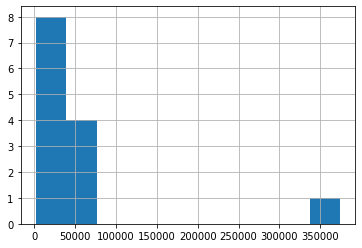

In [ ]:
rgints[variavel].hist();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


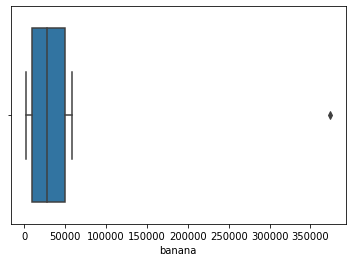

In [ ]:
# boxplot
sns.boxplot(rgints[variavel], orient='v');

In [ ]:
# visualizar as regiões em ordem decrescente (ou crescente)
rgints.sort_values(variavel, ascending=False)[['nome_rgint', variavel]].head(10)

nome_rgint  banana
1          Montes Claros  374276
0         Belo Horizonte   58724
8           Pouso Alegre   56393
7               Varginha   50287
10            Uberlândia   39121
2          Teófilo Otoni   31631
5           Juíz de Fora   27433
4               Ipatinga   19268
11        Patos de Minas    9621
3   Governador Valadares    9489

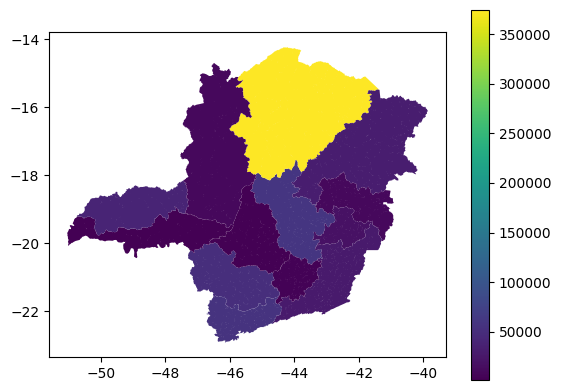

In [46]:
# mapa temático - simples
rgints.plot(variavel, legend=True);

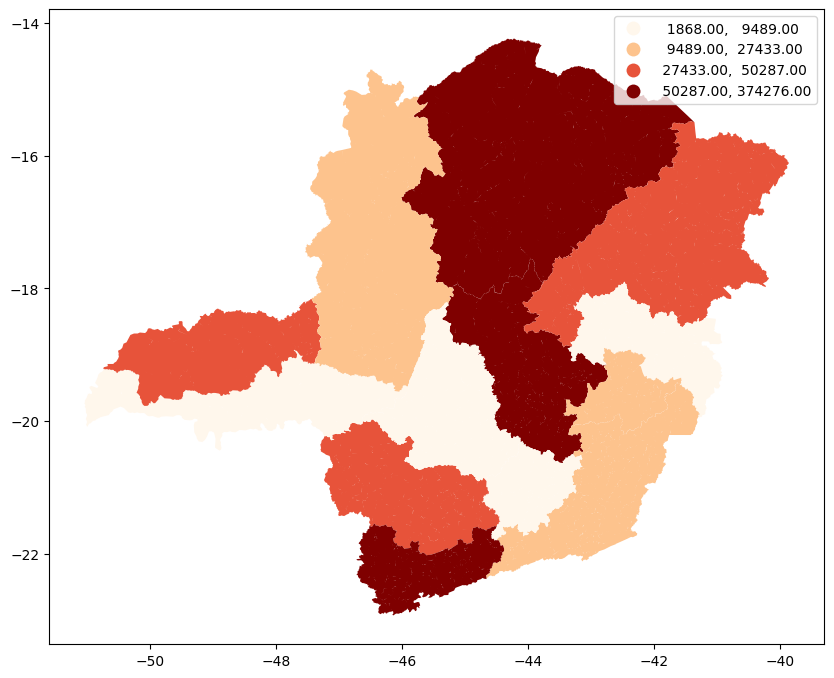

In [47]:
# mapa temático - quantiles
rgints.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

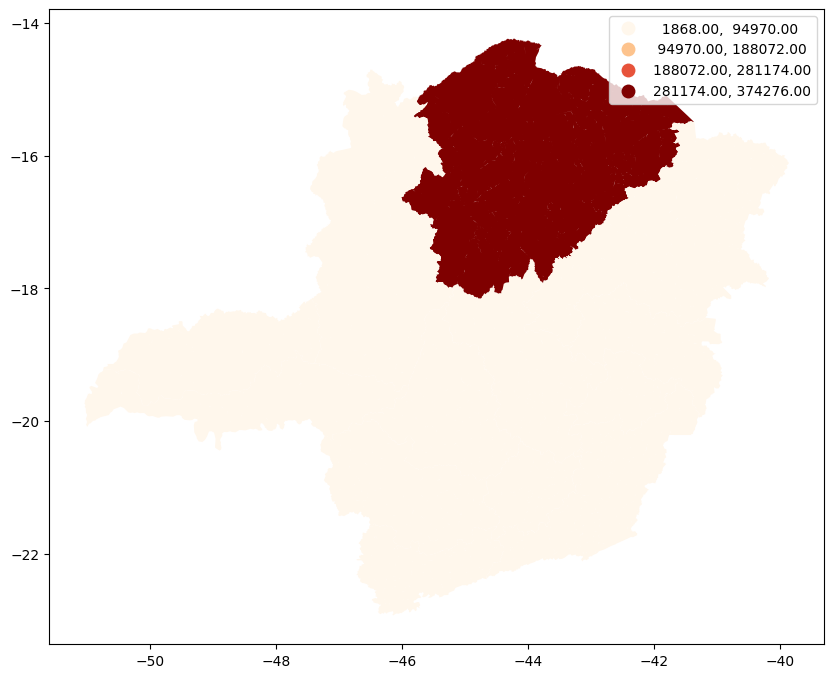

In [48]:
# mapa temático - equal_interval
rgints.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [50]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(rgints)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = rgints[variavel].values
moran = Moran(y, w)
moran.I

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\647786615.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(rgints)


-0.03322953883249131

In [51]:
# valor-p
moran.p_sim

0.239

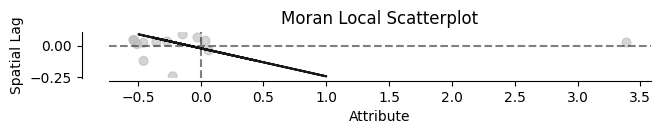

In [52]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

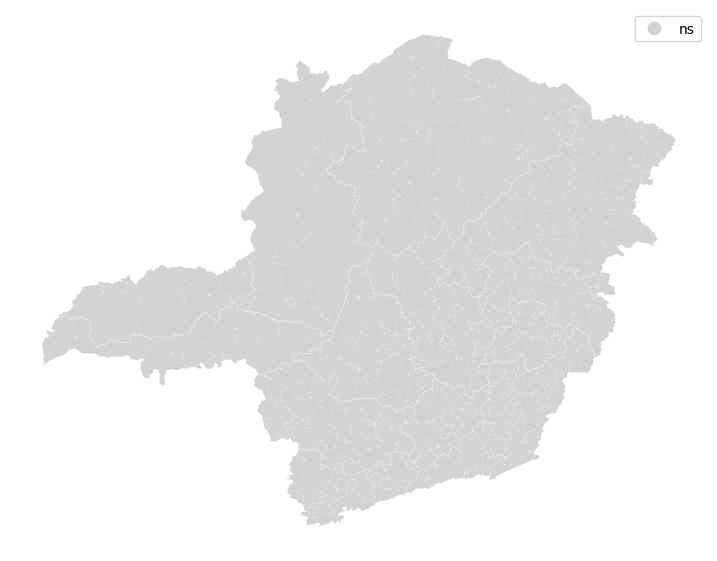

In [53]:
# mapa LISA
lisa_cluster(moran_loc, rgints, p=0.05, figsize = (9,9));

# Nível de agregação: regiões imediatas

In [54]:
mg.columns

Index(['mun', 'geometry', 'nome_mun', 'uf', 'nome_uf', 'rm', 'meso',
       'nome_meso', 'micro', 'nome_micro', 'cod_rgi', 'nome_rgi', 'cod_rgint',
       'nome_rgint', 'codmun6', 'regiao', 'nome_regiao', 'area', 'algodao_arb',
       'algodao_herb', 'banana', 'batata', 'cafe_arab', 'cana', 'feijao',
       'laranja', 'limao', 'manga', 'milho', 'soja', 'sorgo', 'tangerina',
       'tomate', 'trigo', 'leite', 'ovos', 'mel'],
      dtype='object')

In [57]:
# somar os valores dos municípios presentes em cada região imediata
rgis = mg.dissolve(by=['cod_rgi', 'nome_rgi'], aggfunc='sum')
rgis.head(3)

geometry  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              POLYGON ((-43.96069 -20.40077, -43.99903 -20.3...   
310002  Sete Lagoas                 POLYGON ((-44.21319 -19.59943, -44.22376 -19.5...   
310003  Santa Bárbara - Ouro Preto  POLYGON ((-43.41267 -20.56769, -43.41610 -20.5...   

                                         mun  \
cod_rgi nome_rgi                               
310001  Belo Horizonte              91049897   
310002  Sete Lagoas                 59485594   
310003  Santa Bárbara - Ouro Preto  18795971   

                                                                             nome_mun  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              Belo HorizonteBetimBrumadinhoCaetéConfinsConta...   
310002  Sete Lagoas                 AraçaíBaldimCachoeira da PrataCaetanópolisCapi...   
310003  Santa Bárbara - Ouro Preto  Barão de CocaisCatas AltasItabiritoMarianaOuro...   

                                     uf  \
cod_rgi nome_rgi                          
310001  Belo Horizonte              899   
310002  Sete Lagoas                 589   
310003  Santa Bárbara - Ouro Preto  186   

                                                                              nome_uf  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
310002  Sete Lagoas                 Minas GeraisMinas GeraisMinas GeraisMinas Gera...   
310003  Santa Bárbara - Ouro Preto  Minas GeraisMinas GeraisMinas GeraisMinas Gera...   

                                                                                   rm  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              RM Belo HorizonteRM Belo HorizonteRM Belo Hori...   
310002  Sete Lagoas                 RM Belo HorizonteRM Belo HorizonteRM Belo Hori...   
310003  Santa Bárbara - Ouro Preto  RM Belo HorizonteRM Belo HorizonteRM Belo Hori...   

                                     meso  \
cod_rgi nome_rgi                            
310001  Belo Horizonte              90103   
310002  Sete Lagoas                 59033   
310003  Santa Bárbara - Ouro Preto  18642   

                                                                            nome_meso  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              Metropolitana de Belo HorizonteMetropolitana d...   
310002  Sete Lagoas                 Metropolitana de Belo HorizonteMetropolitana d...   
310003  Santa Bárbara - Ouro Preto  Metropolitana de Belo HorizonteMetropolitana d...   

                                     micro  \
cod_rgi nome_rgi                             
310001  Belo Horizonte              899870   
310002  Sete Lagoas                 589516   
310003  Santa Bárbara - Ouro Preto  186192   

                                                                           nome_micro  \
cod_rgi nome_rgi                                                                        
310001  Belo Horizonte              Belo HorizonteBelo HorizonteBelo HorizonteBelo...   
310002  Sete Lagoas                 Sete LagoasSete LagoasSete LagoasSete LagoasSe...   
310003  Santa Bárbara - Ouro Preto  ItabiraItabiraOuro PretoOuro PretoOuro PretoIt...   

                                    ...  manga milho  soja  sorgo tangerina  \
cod_rgi nome_rgi                    ...                                       
310001  Belo Horizonte              ...    207  4267     0      0     10617   
310002  Sete Lagoas                 ...   1432  5983  2306    116       230   
310003  Santa Bárbara - Ouro Preto  ...     12   713     0      0         0   

                                    tomate  trigo   leite   ovos     mel  
cod_rgi nome_rgi

In [58]:
# reiniciar índices
rgis = rgis.reset_index()

In [59]:
# resumo estatístico
rgis[variavel].describe()

count        70.000000
mean       9792.442857
std       35478.338963
min           0.000000
25%         459.500000
50%        1400.000000
75%        5693.500000
max      289949.000000
Name: banana, dtype: float64

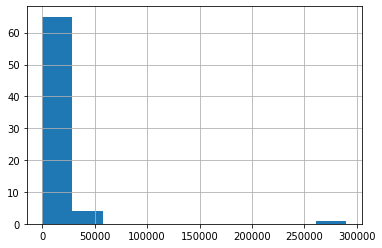

In [ ]:
rgis[variavel].hist();

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_core.py:1326: UserWarning: Vertical orientation ignored with only `x` specified.
  warnings.warn(single_var_warning.format("Vertical", "x"))


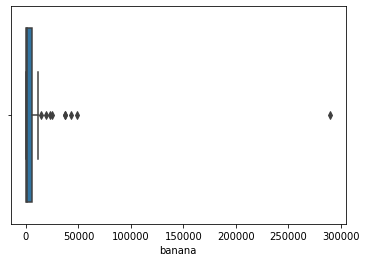

In [ ]:
# boxplot
sns.boxplot(rgis[variavel], orient='v');

In [60]:
# visualizar as regiões em ordem decrescente (ou crescente)
rgis.sort_values(variavel, ascending=False)[['nome_rgi', variavel]].head(10)

nome_rgi  banana
6          Janaúba  289949
0   Belo Horizonte   48458
40          Passos   43189
58      Uberlândia   36973
5    Montes Claros   36828
9         Pirapora   24741
51         Itajubá   23051
52    São Lourenço   18676
24       Caratinga   14731
16         Araçuaí   11610

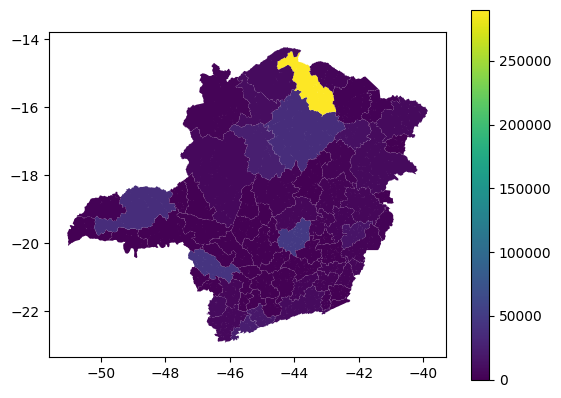

In [61]:
# mapa temático - simples
rgis.plot(variavel, legend=True);

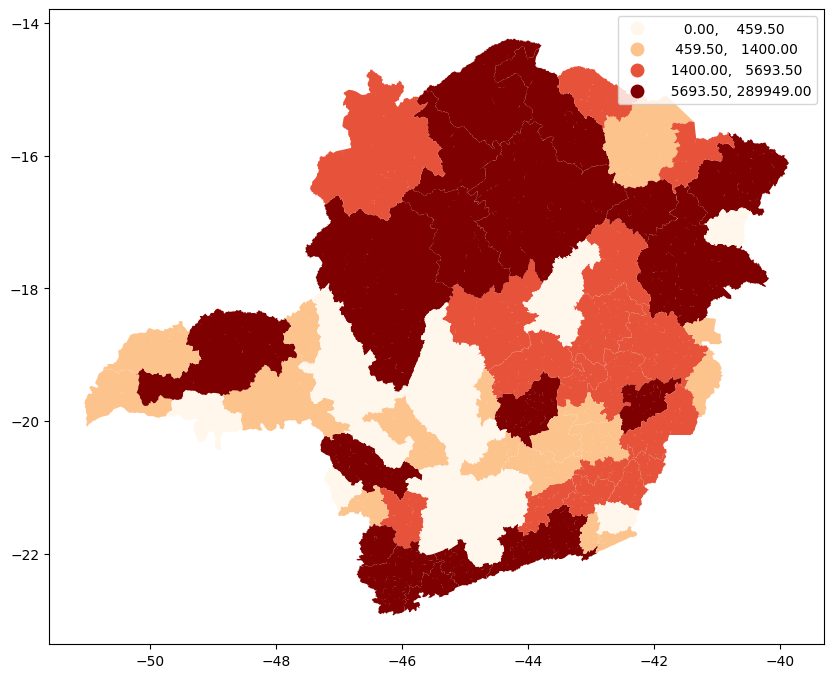

In [62]:
# mapa temático - quantiles
rgis.plot(column=variavel, figsize=(10, 10), scheme='Quantiles', cmap='OrRd', legend=True, k=4);

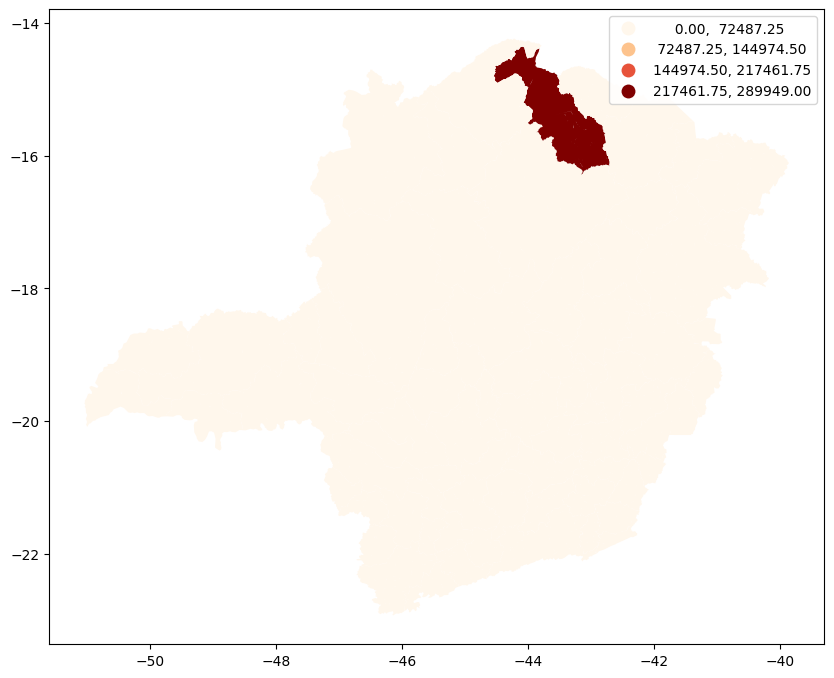

In [63]:
# mapa temático - equal_interval
rgis.plot(column=variavel, figsize=(10, 10), scheme='Equal_Interval', cmap='OrRd', legend=True, k=4);

In [64]:
# obter matriz de vizinhança no formato queen
w = Queen.from_dataframe(rgis)
w.transform = 'r'
# calcular I de Moran global para a variável escolhida
y = rgis[variavel].values
moran = Moran(y, w)
moran.I

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\3948250770.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(rgis)


0.005163729339951901

In [65]:
# valor-p
moran.p_sim

0.244

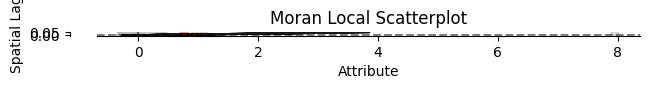

In [66]:
# só o diagrama de dispersão
moran_loc = Moran_Local(y, w)
moran_scatterplot(moran_loc, p=0.05);

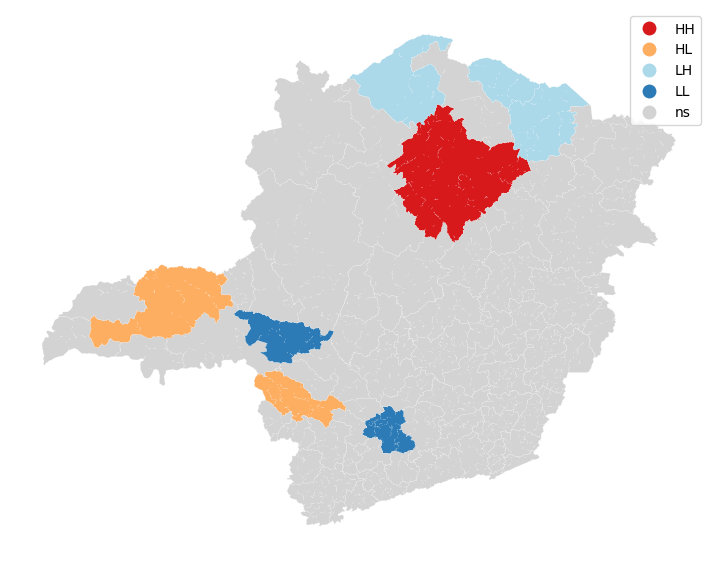

In [67]:
# mapa LISA
lisa_cluster(moran_loc, rgis, p=0.05, figsize = (9,9));

# Apenas LISA em diferentes níveis de agregação

In [68]:
results = []

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\3734179948.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(mg)


0.16236018405991934 0.001


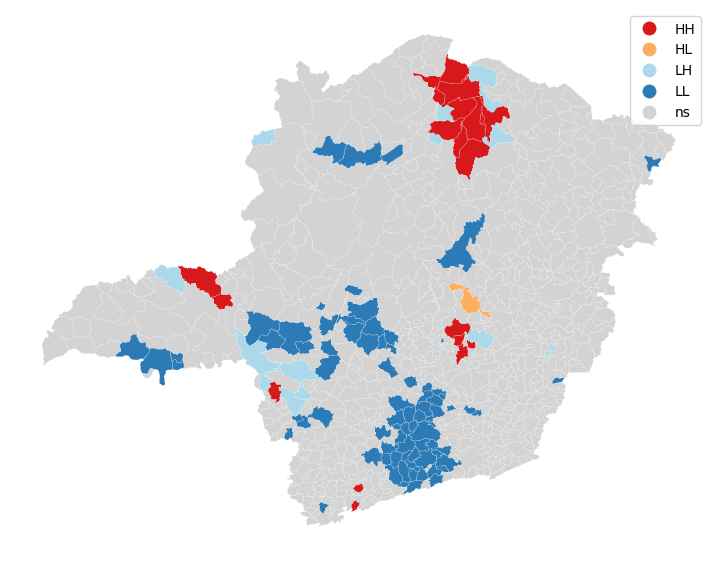

In [69]:
w = Queen.from_dataframe(mg)
w.transform = 'r'
y = mg[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, mg, p=0.05, figsize = (9,9));
print(moran.I, moran.p_sim)
results.append([moran.I, moran.p_sim])

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\4102569776.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(mesos)


-0.15700987910828637 0.204


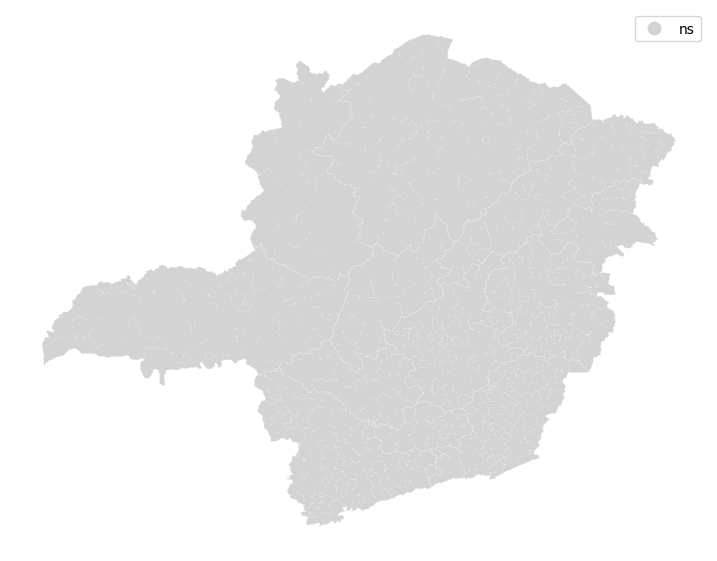

In [70]:
w = Queen.from_dataframe(mesos)
w.transform = 'r'
y = mesos[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, mesos, p=0.05, figsize = (9,9));
print(moran.I, moran.p_sim)
results.append([moran.I, moran.p_sim])

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\1033015128.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(micros)


0.13330079217195764 0.009


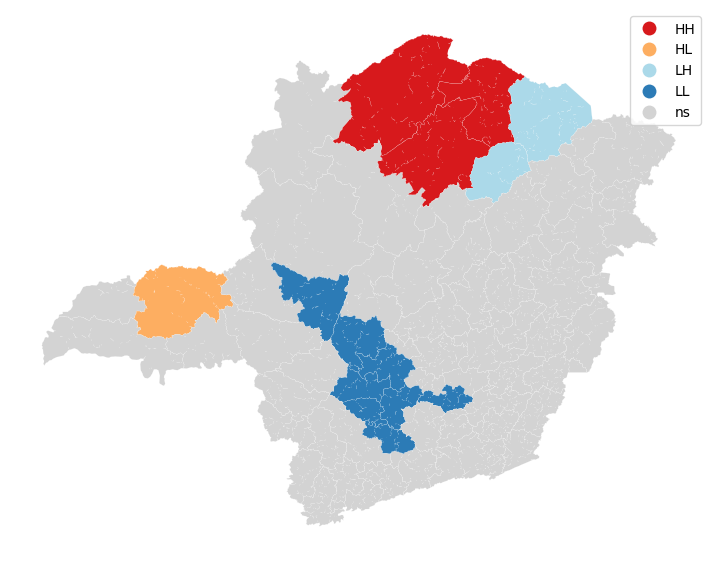

In [71]:
w = Queen.from_dataframe(micros)
w.transform = 'r'
y = micros[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, micros, p=0.05, figsize = (9,9));
print(moran.I, moran.p_sim)
results.append([moran.I, moran.p_sim])

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\2059377445.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(rgints)


-0.03322953883249131 0.218


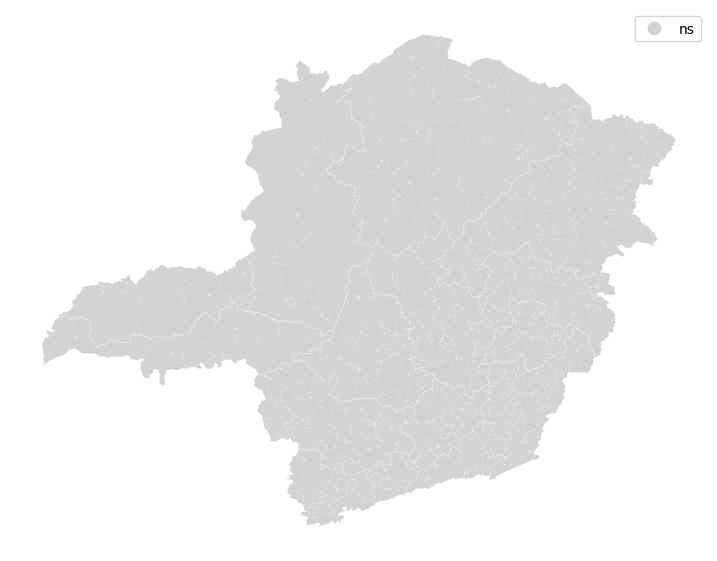

In [72]:
w = Queen.from_dataframe(rgints)
w.transform = 'r'
y = rgints[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, rgints, p=0.05, figsize = (9,9));
print(moran.I, moran.p_sim)
results.append([moran.I, moran.p_sim])

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\3330997128.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(rgis)


0.005163729339951901 0.228


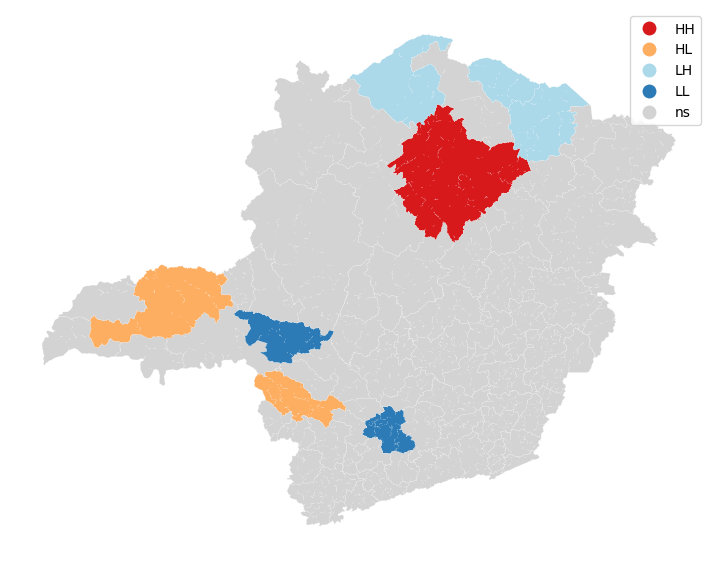

In [73]:
w = Queen.from_dataframe(rgis)
w.transform = 'r'
y = rgis[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)
lisa_cluster(moran_loc, rgis, p=0.05, figsize = (9,9));
print(moran.I, moran.p_sim)
results.append([moran.I, moran.p_sim])

In [74]:
results

[[0.16236018405991934, 0.001],
 [-0.15700987910828637, 0.204],
 [0.13330079217195764, 0.009],
 [-0.03322953883249131, 0.218],
 [0.005163729339951901, 0.228]]

In [75]:
# dicionário de dataframes
niveis = {
  'mg': mg,
  'mesos': mesos,
  'micros': micros,
  'rgints': rgints,
  'rgis': rgis
}

C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\1951096671.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(niveis[k])
C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\1951096671.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(niveis[k])
C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\1951096671.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(niveis[k])
C:\Users\Luan Lima\AppData\Local\Temp\ipykernel_27636\1951096671.py:2: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and sil

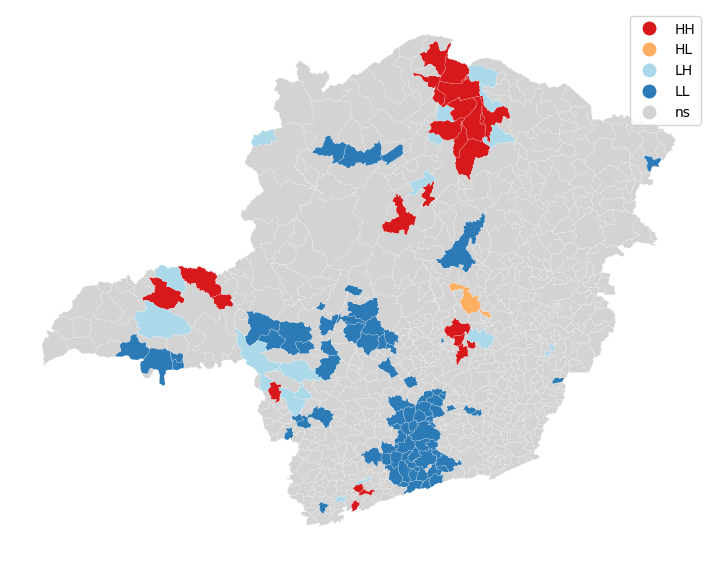

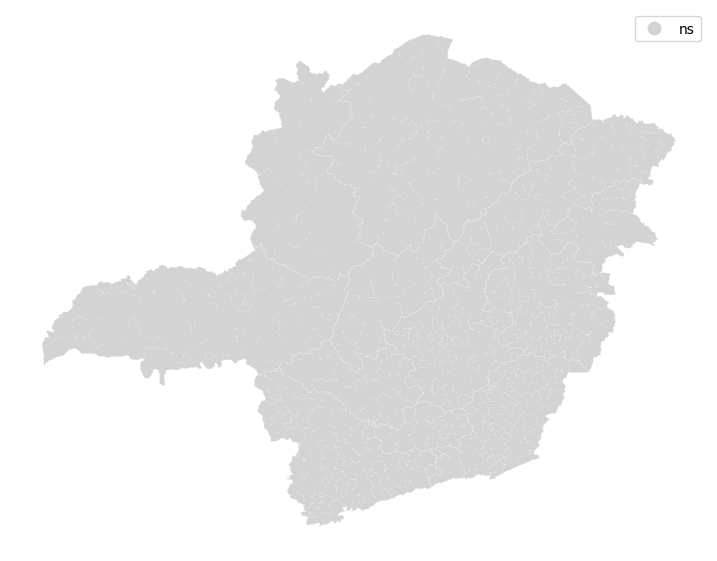

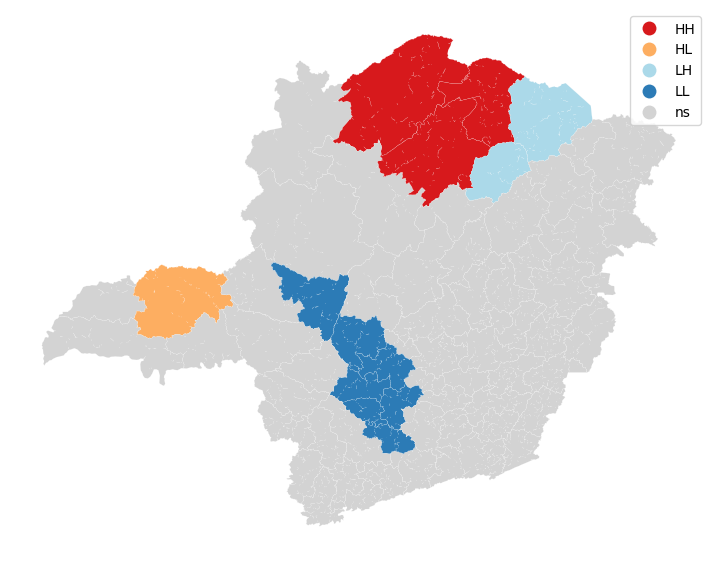

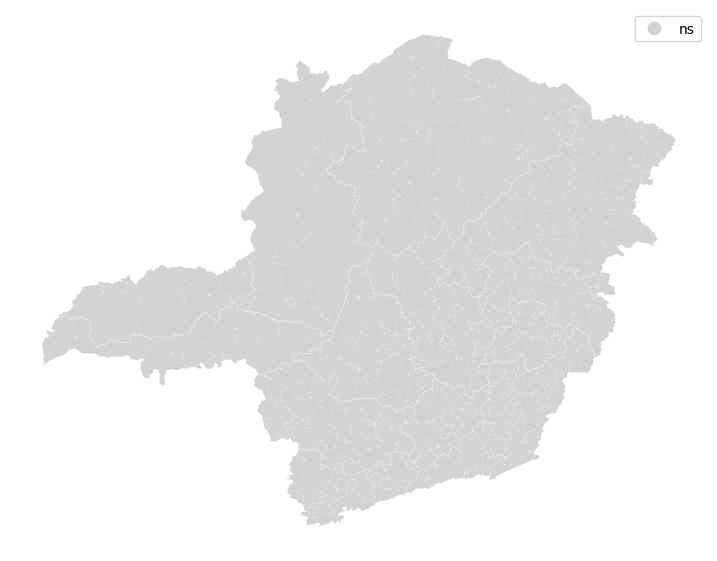

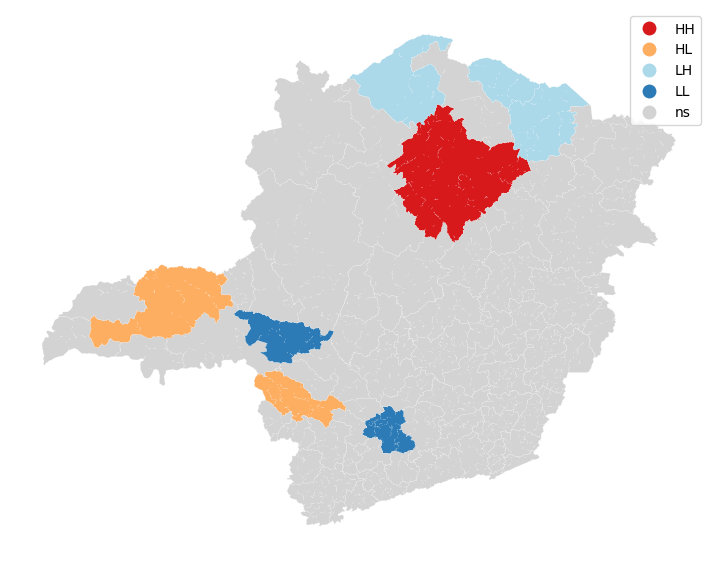

In [76]:
for k in niveis.keys():
    w = Queen.from_dataframe(niveis[k])
    w.transform = 'r'
    y = niveis[k][variavel].values
    moran = Moran(y, w)
    moran_loc = Moran_Local(y, w)
    lisa_cluster(moran_loc, niveis[k], p=0.05, figsize = (9,9));

In [ ]:
results

[[0.16236018405991934, 0.001],
 [-0.15700987910828637, 0.211],
 [0.13330079217195764, 0.011],
 [-0.03322953883249131, 0.232],
 [0.005163729339951901, 0.24]]

In [ ]:
# dicionário de dataframes
niveis = {
  'mg': mg,
  'mesos': mesos,
  'micros': micros,
  'rgints': rgints,
  'rgis': rgis
}

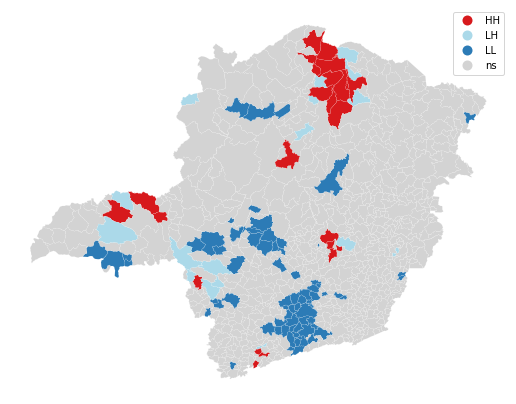

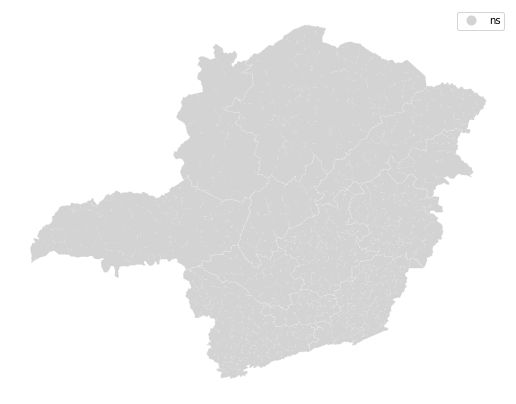

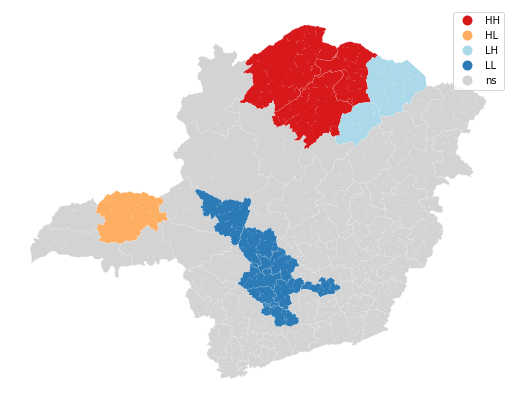

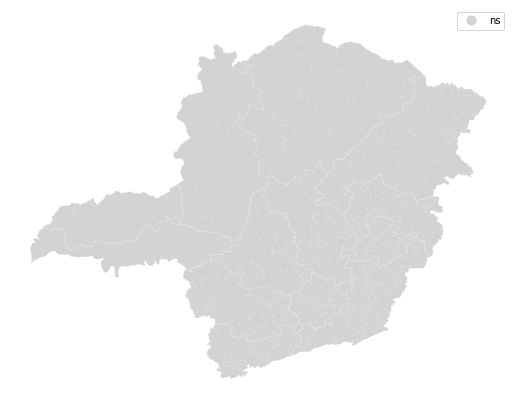

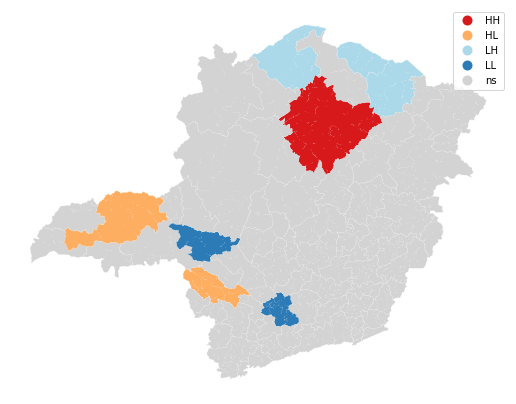

In [ ]:
for k in niveis.keys():
    w = Queen.from_dataframe(niveis[k])
    w.transform = 'r'
    y = niveis[k][variavel].values
    moran = Moran(y, w)
    moran_loc = Moran_Local(y, w)
    lisa_cluster(moran_loc, niveis[k], p=0.05, figsize = (9,9));

# Inclusão dos nomes - LISA

In [ ]:
# para evitar problemas com os nomes: https://gis.stackexchange.com/questions/372564/userwarning-when-trying-to-get-centroid-from-a-polygon-geopandas
mg = mg.to_crs(epsg=3395)
mesos = mesos.to_crs(epsg=3395)
micros = micros.to_crs(epsg=3395)
rgints = rgints.to_crs(epsg=3395)
rgis = rgis.to_crs(epsg=3395)

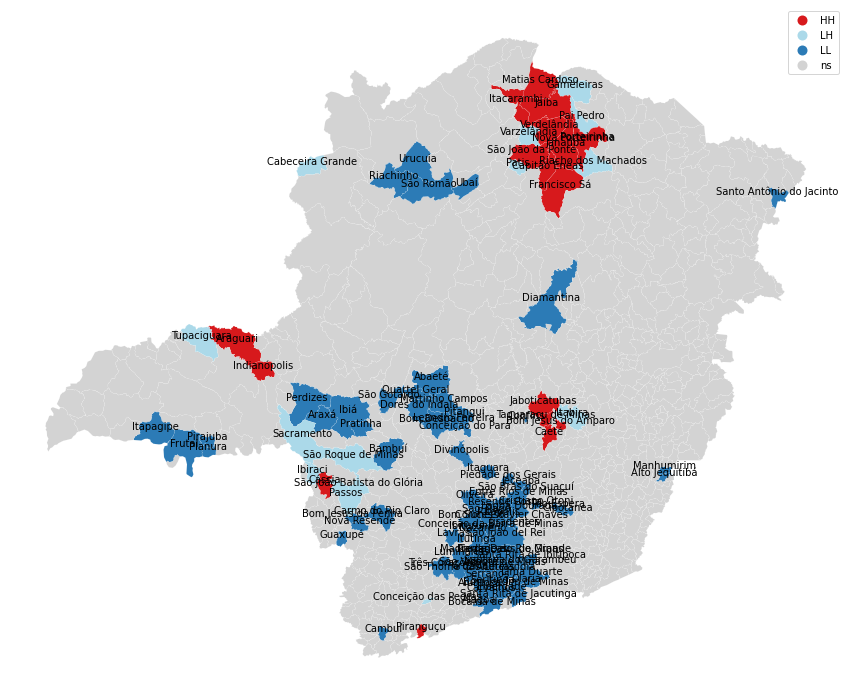

In [ ]:
# municípios
w = Queen.from_dataframe(mg)
w.transform = 'r'
y = mg[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)

fig, ax = plt.subplots(1, figsize=(15, 15))
lisa_cluster(moran_loc, mg, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = mg.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_mun[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

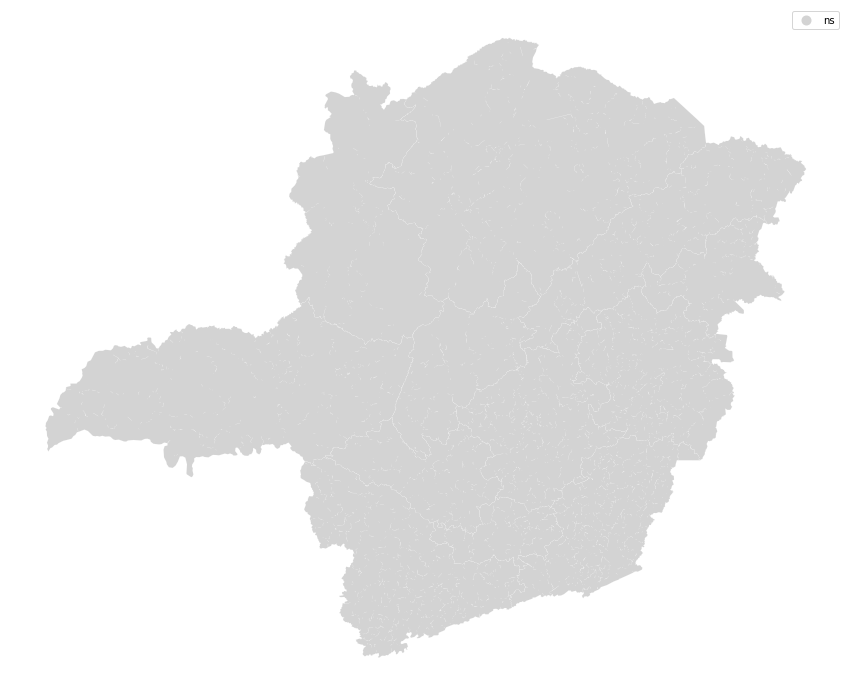

In [ ]:
w = Queen.from_dataframe(mesos)
w.transform = 'r'
y = mesos[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)

fig, ax = plt.subplots(1, figsize=(15, 15))
lisa_cluster(moran_loc, mesos, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = mesos.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_meso[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

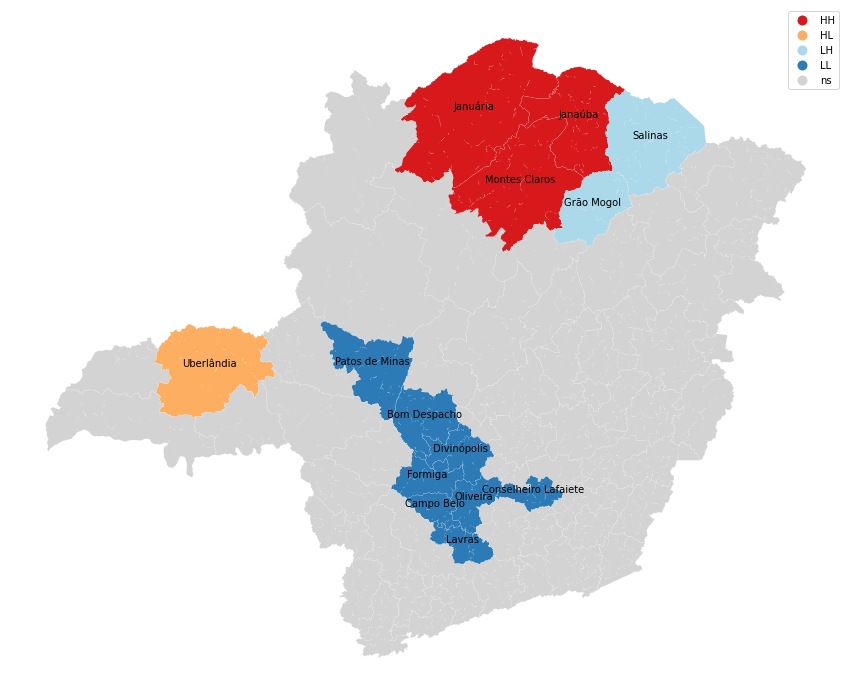

In [ ]:
w = Queen.from_dataframe(micros)
w.transform = 'r'
y = micros[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)

fig, ax = plt.subplots(1, figsize=(15, 15))
lisa_cluster(moran_loc, micros, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = micros.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_micro[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

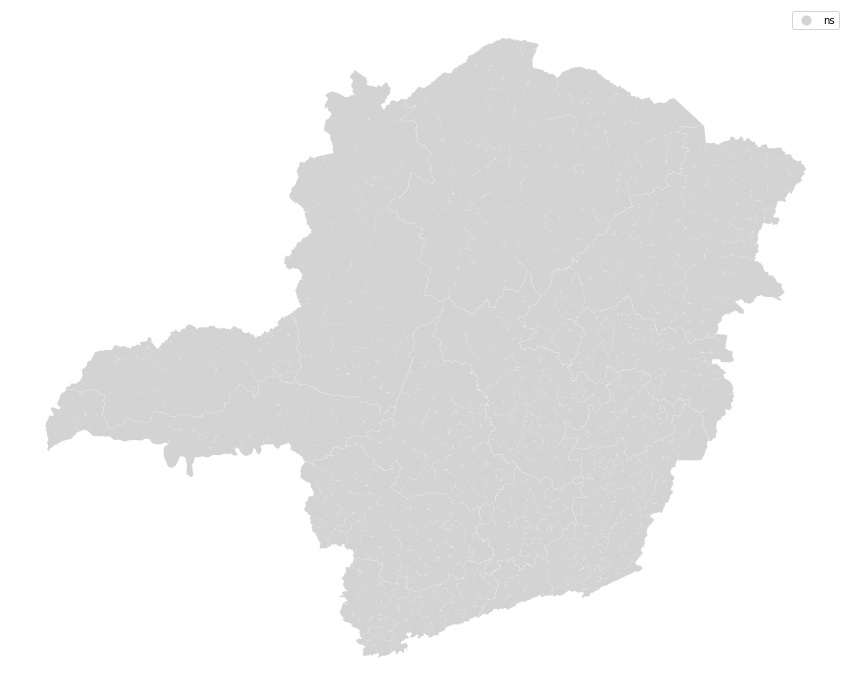

In [ ]:
w = Queen.from_dataframe(rgints)
w.transform = 'r'
y = rgints[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)

fig, ax = plt.subplots(1, figsize=(15, 15))
lisa_cluster(moran_loc, rgints, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = rgints.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_rgint[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')

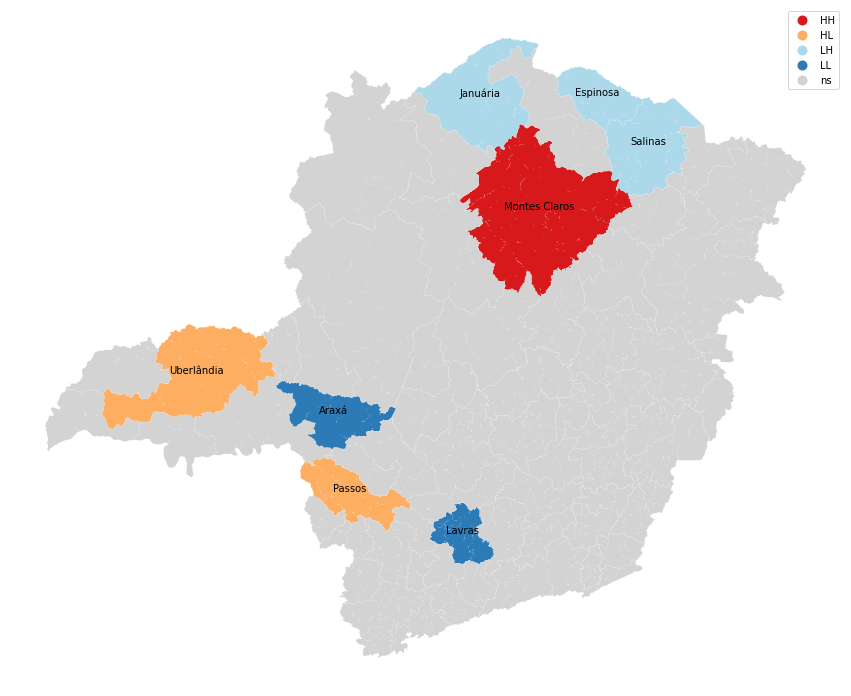

In [ ]:
w = Queen.from_dataframe(rgis)
w.transform = 'r'
y = rgis[variavel].values
moran = Moran(y, w)
moran_loc = Moran_Local(y, w)

fig, ax = plt.subplots(1, figsize=(15, 15))
lisa_cluster(moran_loc, rgis, p=0.05, ax=ax, figsize = (9,9));
sig = moran_loc.p_sim < 0.05
posicoes = np.where(sig)
escolhidos = rgis.iloc[posicoes[0]]
for j in escolhidos.index:
    ax.text(escolhidos.geometry.centroid[j].coords[0][0], escolhidos.geometry.centroid[j].coords[0][1],
         escolhidos.nome_rgi[j],
         fontsize=10, horizontalalignment='center', verticalalignment='bottom')